In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import gamma
import numpy as np
import c3aidatalake

# Consolidating all Factors into Single CSV File

* Proportion of all High-Risk Diseases
* Proportion of Unemployment
* Medical Preparedness
* Proportion of Race
* Social Distance Grade Score by Month
    * Will need to offset for incubation period (let's try without it first)
* Cases by Rural

## Mainland Counties FIPS (from All_County_List.ipynb) - Because of the missing data consistently from Alaska and Hawaii

In [2]:
fips = pd.read_csv('./all_counties_model/mainland_counties_fips.csv')
fips

,fips_code,county,state,c3_data_id
0,1001.0,Autauga,Alabama,Autauga_Alabama_UnitedStates
1,1003.0,Baldwin,Alabama,Baldwin_Alabama_UnitedStates
2,1005.0,Barbour,Alabama,Barbour_Alabama_UnitedStates
3,1007.0,Bibb,Alabama,Bibb_Alabama_UnitedStates
4,1009.0,Blount,Alabama,Blount_Alabama_UnitedStates
...,...,...,...,...
3102,56037.0,Sweetwater,Wyoming,Sweetwater_Wyoming_UnitedStates
3103,56039.0,Teton,Wyoming,Teton_Wyoming_UnitedStates
3104,56041.0,Uinta,Wyoming,Uinta_Wyoming_UnitedStates
3105,56043.0,Washakie,Wyoming,Washakie_Wyoming_UnitedStates


----

# Adding in County Level High Risk Disease

In [3]:
disease = pd.read_csv('./all_counties_model/all_county_disease.csv')
disease

,COUNTY_NAME,STATE_NAME,FIPS,county_pop2018_18 and older,anycondition_number,Obesity_number,Heart disease_number,COPD_number,diabetes_number,CKD_number,proportionAnyCondition,proportionObese,proportionHeartDisease,proportionCOPD,proportionDiabetes,proportionCKD
0,Autauga,Alabama,1001,42438,20181,15193,3345,3644,5462,1326,0.475541,0.358005,0.078821,0.085866,0.128705,0.031246
1,Baldwin,Alabama,1003,170912,68790,50761,13414,14692,20520,5479,0.402488,0.297001,0.078485,0.085962,0.120062,0.032057
2,Barbour,Alabama,1005,19689,11325,8013,2159,2373,3870,887,0.575194,0.406979,0.109655,0.120524,0.196556,0.045051
3,Bibb,Alabama,1007,17813,9190,6894,1533,1789,2511,595,0.515915,0.387021,0.086061,0.100432,0.140964,0.033403
4,Blount,Alabama,1009,44448,20584,15112,4101,4661,6017,1507,0.463103,0.339993,0.092265,0.104864,0.135372,0.033905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,Sweetwater,Wyoming,56037,31761,12796,10672,1862,2098,2834,821,0.402884,0.336010,0.058625,0.066056,0.089229,0.025849
3138,Teton,Wyoming,56039,18842,4576,3655,981,928,1360,447,0.242862,0.193982,0.052065,0.049252,0.072179,0.023724
3139,Uinta,Wyoming,56041,14455,6101,4944,1034,1163,1500,430,0.422068,0.342027,0.071532,0.080457,0.103770,0.029747
3140,Washakie,Wyoming,56043,6092,2285,1730,500,506,686,207,0.375082,0.283979,0.082075,0.083060,0.112607,0.033979


In [4]:
## We will be using any condition because the conditions 
## are not mutually exclusive (ex. can be obeses and also have heart disease, so we want to avoid excess counts)

## Isolating only rural counties
fips_hrd = fips.merge(disease[['FIPS', 'proportionAnyCondition']], how = 'left', left_on = ['fips_code'], right_on = ['FIPS'])
## Dropped unnecessary identifier columns
fips_hrd = fips_hrd.drop(columns = ['county', 'state', 'c3_data_id','FIPS']).rename(columns = {'proportionAnyCondition':'highrisk_prop'})
fips_hrd

,fips_code,highrisk_prop
0,1001.0,0.475541
1,1003.0,0.402488
2,1005.0,0.575194
3,1007.0,0.515915
4,1009.0,0.463103
...,...,...
3102,56037.0,0.402884
3103,56039.0,0.242862
3104,56041.0,0.422068
3105,56043.0,0.375082


`fips_hrd` has fewer counties because of the 4 from AK and HI that are removed in the `mainland_counties_fips.csv`

----

# Adding in County Level Unemployment Rate

In [5]:
raw_c3_data = pd.read_csv('raw_counties_info.csv')
raw_c3_data

,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,populationOfAllChildren,latestLaborForce,latestEmployedPopulation,latestUnemployedPopulation,latestUnemploymentRate,laborForceOfAllChildren,locationType,populationCDS,id,name,typeIdent,location.value.id,location.timestamp,fips.id
0,6.0,25.0,25.0,24527.0,24527.0,10090.0,9633.0,457.0,4.529237,10090.0,county,24527.0,Abbeville_SouthCarolina_UnitedStates,Abbeville,EP_LOC,Abbeville_SouthCarolina_UnitedStates,2020-11-11T00:00:00Z,45001.0
1,7.0,171.0,186.0,62045.0,62045.0,24074.0,22369.0,1705.0,7.082329,24074.0,county,62045.0,Acadia_Louisiana_UnitedStates,Acadia,EP_LOC,Acadia_Louisiana_UnitedStates,2020-11-11T00:00:00Z,22001.0
2,10.0,46.0,52.0,32316.0,32316.0,16001.0,15096.0,905.0,5.655897,16001.0,county,32316.0,Accomack_Virginia_UnitedStates,Accomack,EP_LOC,Accomack_Virginia_UnitedStates,2020-11-11T00:00:00Z,51001.0
3,97.0,1195.0,1305.0,481587.0,481587.0,263531.0,248015.0,15516.0,5.887732,263531.0,county,481587.0,Ada_Idaho_UnitedStates,Ada,EP_LOC,Ada_Idaho_UnitedStates,2020-11-11T00:00:00Z,16001.0
4,4.0,25.0,25.0,7152.0,7152.0,3862.0,3747.0,115.0,2.977732,3862.0,county,7152.0,Adair_Iowa_UnitedStates,Adair,EP_LOC,Adair_Iowa_UnitedStates,2020-11-11T00:00:00Z,19001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,42.0,447.0,456.0,213787.0,213787.0,97557.0,80938.0,16619.0,17.035169,97557.0,county,213787.0,Yuma_Arizona_UnitedStates,Yuma,EP_LOC,Yuma_Arizona_UnitedStates,2020-11-11T00:00:00Z,4027.0
3148,6.0,30.0,30.0,10019.0,10019.0,5010.0,4868.0,142.0,2.834331,5010.0,county,10019.0,Yuma_Colorado_UnitedStates,Yuma,EP_LOC,Yuma_Colorado_UnitedStates,2020-11-11T00:00:00Z,8125.0
3149,NaN,NaN,NaN,14179.0,14179.0,4947.0,4268.0,679.0,13.725490,4947.0,county,14179.0,Zapata_Texas_UnitedStates,Zapata,EP_LOC,Zapata_Texas_UnitedStates,2020-11-11T00:00:00Z,48505.0
3150,NaN,NaN,NaN,11840.0,11840.0,3309.0,2748.0,561.0,16.953762,3309.0,county,11840.0,Zavala_Texas_UnitedStates,Zavala,EP_LOC,Zavala_Texas_UnitedStates,2020-11-11T00:00:00Z,48507.0


In [8]:
fips_hrd_unemp = fips_hrd.merge(raw_c3_data[['fips.id','latestUnemploymentRate', "populationCDS"]], left_on = 'fips_code', right_on = 'fips.id')
fips_hrd_unemp['unemployment_proportion'] = fips_hrd_unemp['latestUnemploymentRate']/100
fips_hrd_unemp = fips_hrd_unemp.loc[:, ['fips_code', 'highrisk_prop', 'populationCDS','unemployment_proportion']]
fips_hrd_unemp 

,fips_code,highrisk_prop,populationCDS,unemployment_proportion
0,1001.0,0.475541,55869.0,0.052137
1,1003.0,0.402488,223234.0,0.055240
2,1005.0,0.575194,24686.0,0.086062
3,1007.0,0.515915,22394.0,0.065914
4,1009.0,0.463103,57826.0,0.040285
...,...,...,...,...
3102,56037.0,0.402884,42343.0,0.069848
3103,56039.0,0.242862,23464.0,0.041664
3104,56041.0,0.422068,20226.0,0.063600
3105,56043.0,0.375082,7805.0,0.047112


----

# Medical Preparedness

To measure medical preparedness,  We will take a look at ICU Beds, not licensed beds. Licensed beds are all the of the beds that a hospital is licensed to have. This number will include beds reserved for non-covid patients. But because we want to know how prepared a county is for COVID medical preparedness we need to know how many ICU beds they have in total. Not every county in the US has a hospital, checked and referenced a 2020 [Kaiser Health Network Report](https://khn.org/news/as-coronavirus-spreads-widely-millions-of-older-americans-live-in-counties-with-no-icu-beds/) which discussed a lack of ICU Beds.

In [9]:
icu_zeros = raw_c3_data.fillna(value = 0)
icu_zeros

,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,populationOfAllChildren,latestLaborForce,latestEmployedPopulation,latestUnemployedPopulation,latestUnemploymentRate,laborForceOfAllChildren,locationType,populationCDS,id,name,typeIdent,location.value.id,location.timestamp,fips.id
0,6.0,25.0,25.0,24527.0,24527.0,10090.0,9633.0,457.0,4.529237,10090.0,county,24527.0,Abbeville_SouthCarolina_UnitedStates,Abbeville,EP_LOC,Abbeville_SouthCarolina_UnitedStates,2020-11-11T00:00:00Z,45001.0
1,7.0,171.0,186.0,62045.0,62045.0,24074.0,22369.0,1705.0,7.082329,24074.0,county,62045.0,Acadia_Louisiana_UnitedStates,Acadia,EP_LOC,Acadia_Louisiana_UnitedStates,2020-11-11T00:00:00Z,22001.0
2,10.0,46.0,52.0,32316.0,32316.0,16001.0,15096.0,905.0,5.655897,16001.0,county,32316.0,Accomack_Virginia_UnitedStates,Accomack,EP_LOC,Accomack_Virginia_UnitedStates,2020-11-11T00:00:00Z,51001.0
3,97.0,1195.0,1305.0,481587.0,481587.0,263531.0,248015.0,15516.0,5.887732,263531.0,county,481587.0,Ada_Idaho_UnitedStates,Ada,EP_LOC,Ada_Idaho_UnitedStates,2020-11-11T00:00:00Z,16001.0
4,4.0,25.0,25.0,7152.0,7152.0,3862.0,3747.0,115.0,2.977732,3862.0,county,7152.0,Adair_Iowa_UnitedStates,Adair,EP_LOC,Adair_Iowa_UnitedStates,2020-11-11T00:00:00Z,19001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,42.0,447.0,456.0,213787.0,213787.0,97557.0,80938.0,16619.0,17.035169,97557.0,county,213787.0,Yuma_Arizona_UnitedStates,Yuma,EP_LOC,Yuma_Arizona_UnitedStates,2020-11-11T00:00:00Z,4027.0
3148,6.0,30.0,30.0,10019.0,10019.0,5010.0,4868.0,142.0,2.834331,5010.0,county,10019.0,Yuma_Colorado_UnitedStates,Yuma,EP_LOC,Yuma_Colorado_UnitedStates,2020-11-11T00:00:00Z,8125.0
3149,0.0,0.0,0.0,14179.0,14179.0,4947.0,4268.0,679.0,13.725490,4947.0,county,14179.0,Zapata_Texas_UnitedStates,Zapata,EP_LOC,Zapata_Texas_UnitedStates,2020-11-11T00:00:00Z,48505.0
3150,0.0,0.0,0.0,11840.0,11840.0,3309.0,2748.0,561.0,16.953762,3309.0,county,11840.0,Zavala_Texas_UnitedStates,Zavala,EP_LOC,Zavala_Texas_UnitedStates,2020-11-11T00:00:00Z,48507.0


In [10]:
icu_zeros['icu_beds_per_capita'] = icu_zeros['hospitalIcuBeds']/icu_zeros['populationCDS']
icu_zeros = icu_zeros.rename(columns = {'fips.id': 'fips_code'})

In [11]:
min(icu_zeros['icu_beds_per_capita']), max(icu_zeros['icu_beds_per_capita'])

(0.0, 0.004114097641250686)

In [12]:
min(icu_zeros['hospitalIcuBeds']), max(icu_zeros['hospitalIcuBeds'])

(0.0, 2352.0)

There is very clearly a shortage of beds available per person in the US. And Not very many ICU beds prepared in general.

In [13]:
fips_hrd_unemp_med = fips_hrd_unemp.merge(icu_zeros[['fips_code','icu_beds_per_capita']], on='fips_code')
fips_hrd_unemp_med

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita
0,1001.0,0.475541,55869.0,0.052137,0.000107
1,1003.0,0.402488,223234.0,0.055240,0.000228
2,1005.0,0.575194,24686.0,0.086062,0.000203
3,1007.0,0.515915,22394.0,0.065914,0.000179
4,1009.0,0.463103,57826.0,0.040285,0.000104
...,...,...,...,...,...
3102,56037.0,0.402884,42343.0,0.069848,0.000307
3103,56039.0,0.242862,23464.0,0.041664,0.000256
3104,56041.0,0.422068,20226.0,0.063600,0.000297
3105,56043.0,0.375082,7805.0,0.047112,0.000384


---

# Social Distancing Grade (Outside Source: Unacast)

In [17]:
unacast_raw = pd.read_csv('./rural_resurgence/unacast/unacast_all.csv')
unacast_all = fips.merge(unacast_raw, how = 'left', left_on = 'fips_code', right_on = 'countyFips')
unacast_all['countyFips'].nunique()

3106

The District of Columbia isn't available in the Dataset either, can remove later

In [18]:
fips[fips['fips_code'] == 11001]

,fips_code,county,state,c3_data_id
290,11001.0,District of Columbia,District of Columbia,DistrictofColumbia_DistrictofColumbia_UnitedSt...


In [19]:
data[data['countyFips'] == 11001]

,fips_code,county,state,c3_data_id,FIPS,stateFips,stateName,stateCode,countyFips,countyName,date,totalGrade


### Mapping totalGrade Letter Score to a Numeric Value

Originally, the scale from Unacast was from 1-5 with lower scores corresponding to a better social distance grade and so we mapped a similar scale to the totalGrade column for comparison and average grading. We changed the scale from A = 1, B = 2, C = 3, D = 4, F =5 to map it to a more consistent scale to accommodate partial scores (+ and -). Modeled after GPA scaling.

In [20]:
SDG_dict = {"F":5, "D-":4.7,"D": 4.3, "D+":4, "C-":3.7, "C": 3.3, "C+":3, "B-":2.7, "B": 2.3 , "B+":2, "A-":1.7, "A":1, "A+": 1}

In [21]:
unacast_all['grade_num'] = unacast_all['totalGrade'].map(SDG_dict)
unacast_all

,fips_code,county,state,c3_data_id,FIPS,stateFips,stateName,stateCode,countyFips,countyName,date,totalGrade,grade_num
0,1001.0,Autauga,Alabama,Autauga_Alabama_UnitedStates,1.0,1.0,Alabama,AL,1001.0,Autauga County,2020-11-12,F,5.0
1,1001.0,Autauga,Alabama,Autauga_Alabama_UnitedStates,1.0,1.0,Alabama,AL,1001.0,Autauga County,2020-11-11,F,5.0
2,1001.0,Autauga,Alabama,Autauga_Alabama_UnitedStates,1.0,1.0,Alabama,AL,1001.0,Autauga County,2020-11-10,F,5.0
3,1001.0,Autauga,Alabama,Autauga_Alabama_UnitedStates,1.0,1.0,Alabama,AL,1001.0,Autauga County,2020-11-09,F,5.0
4,1001.0,Autauga,Alabama,Autauga_Alabama_UnitedStates,1.0,1.0,Alabama,AL,1001.0,Autauga County,2020-11-08,F,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
822936,56045.0,Weston,Wyoming,Weston_Wyoming_UnitedStates,56.0,56.0,Wyoming,WY,56045.0,Weston County,2020-02-28,C,3.3
822937,56045.0,Weston,Wyoming,Weston_Wyoming_UnitedStates,56.0,56.0,Wyoming,WY,56045.0,Weston County,2020-02-27,C,3.3
822938,56045.0,Weston,Wyoming,Weston_Wyoming_UnitedStates,56.0,56.0,Wyoming,WY,56045.0,Weston County,2020-02-26,C,3.3
822939,56045.0,Weston,Wyoming,Weston_Wyoming_UnitedStates,56.0,56.0,Wyoming,WY,56045.0,Weston County,2020-02-25,C,3.3


### Monthly Social Distance Grade for Each Rural County

In [22]:
import datetime

In [23]:
# date is formatted as string so reformatted to datetime 
unacast_all['month'] = pd.to_datetime(unacast_all['date'], format='%Y-%m-%d').dt.month_name()

# groupby countyFips and date
unacast_month = unacast_all.groupby([unacast_all["countyFips"], unacast_all['month']])['grade_num'].mean()
sdg_month = pd.DataFrame(unacast_month)
sdg_month.index = sdg_month.index.set_names(['countyFips', 'month'])
sdg_month

grade_num
countyFips month               
1001.0     April       4.686667
           August      5.000000
           February    5.000000
           July        5.000000
           June        5.000000
...                         ...
56045.0    March       2.996774
           May         3.054839
           November    2.950000
           October     3.022581
           September   3.100000

[31060 rows x 1 columns]

#### What about the Null Values?

Filling them with the monthly averages from all the counties

In [24]:
average_sdg_per_month = unacast_all.groupby(unacast_all['month'])['grade_num'].mean()
average_sdg_per_month

month
April        3.582099
August       4.303815
February     4.378786
July         4.323155
June         4.305689
March        4.033425
May          4.160776
November     4.050547
October      4.156459
September    4.215199
Name: grade_num, dtype: float64

In [25]:
month_avg = dict(average_sdg_per_month)

### Backfilling Holes

In [26]:
sdg_month.reset_index(inplace = True)
sdg_month

,countyFips,month,grade_num
0,1001.0,April,4.686667
1,1001.0,August,5.000000
2,1001.0,February,5.000000
3,1001.0,July,5.000000
4,1001.0,June,5.000000
...,...,...,...
31055,56045.0,March,2.996774
31056,56045.0,May,3.054839
31057,56045.0,November,2.950000
31058,56045.0,October,3.022581


In [27]:
sdg_month['month_avg'] = sdg_month.month.map(month_avg)

In [28]:
sdg_month

,countyFips,month,grade_num,month_avg
0,1001.0,April,4.686667,3.582099
1,1001.0,August,5.000000,4.303815
2,1001.0,February,5.000000,4.378786
3,1001.0,July,5.000000,4.323155
4,1001.0,June,5.000000,4.305689
...,...,...,...,...
31055,56045.0,March,2.996774,4.033425
31056,56045.0,May,3.054839,4.160776
31057,56045.0,November,2.950000,4.050547
31058,56045.0,October,3.022581,4.156459


In [29]:
sdg_month['grade_num'] = sdg_month['grade_num'].fillna(sdg_month['month_avg'])
sdg_month

,countyFips,month,grade_num,month_avg
0,1001.0,April,4.686667,3.582099
1,1001.0,August,5.000000,4.303815
2,1001.0,February,5.000000,4.378786
3,1001.0,July,5.000000,4.323155
4,1001.0,June,5.000000,4.305689
...,...,...,...,...
31055,56045.0,March,2.996774,4.033425
31056,56045.0,May,3.054839,4.160776
31057,56045.0,November,2.950000,4.050547
31058,56045.0,October,3.022581,4.156459


In [30]:
sdg_month.isna().sum()

countyFips    0
month         0
grade_num     0
month_avg     0
dtype: int64

In [31]:
sdg_month

,countyFips,month,grade_num,month_avg
0,1001.0,April,4.686667,3.582099
1,1001.0,August,5.000000,4.303815
2,1001.0,February,5.000000,4.378786
3,1001.0,July,5.000000,4.323155
4,1001.0,June,5.000000,4.305689
...,...,...,...,...
31055,56045.0,March,2.996774,4.033425
31056,56045.0,May,3.054839,4.160776
31057,56045.0,November,2.950000,4.050547
31058,56045.0,October,3.022581,4.156459


In [32]:
sdg_pivot = sdg_month.pivot(index = "countyFips", columns = "month", values = "grade_num")
sdg_pivot

month,April,August,February,July,June,March,May,November,October,September
countyFips,,,,,,,,,,
1001.0,4.686667,5.000000,5.00,5.000000,5.000000,4.929032,5.000000,5.000000,5.000000,5.000000
1003.0,3.943333,5.000000,5.00,5.000000,5.000000,4.703226,5.000000,5.000000,5.000000,4.800000
1005.0,4.040000,4.509677,4.75,4.745455,4.743333,4.441935,4.748387,4.275000,4.338710,4.430000
1007.0,4.183333,4.841935,4.95,4.872727,4.910000,4.580645,4.841935,4.391667,4.629032,4.696667
1009.0,4.733333,5.000000,5.00,5.000000,5.000000,4.822581,5.000000,5.000000,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...
56037.0,3.936667,4.000000,4.00,4.000000,4.000000,3.967742,4.000000,4.000000,3.977419,3.976667
56039.0,1.573333,3.429032,3.30,3.700000,3.460000,2.703226,2.529032,2.716667,3.280645,3.300000
56041.0,2.973333,4.029032,4.00,4.054545,4.000000,3.525806,3.861290,3.975000,3.990323,3.990000


# Final CSV of Data

### Basic Static table with demographic data
Have: 
* rural counties key (rural df)
* Proportion of High Risk (rural_conditions_proportion df)
* SDG (sdg_month df)

In [33]:
fips_hrd_unemp_med

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita
0,1001.0,0.475541,55869.0,0.052137,0.000107
1,1003.0,0.402488,223234.0,0.055240,0.000228
2,1005.0,0.575194,24686.0,0.086062,0.000203
3,1007.0,0.515915,22394.0,0.065914,0.000179
4,1009.0,0.463103,57826.0,0.040285,0.000104
...,...,...,...,...,...
3102,56037.0,0.402884,42343.0,0.069848,0.000307
3103,56039.0,0.242862,23464.0,0.041664,0.000256
3104,56041.0,0.422068,20226.0,0.063600,0.000297
3105,56043.0,0.375082,7805.0,0.047112,0.000384


In [34]:
fips_hrd_unemp_med_sdg = fips_hrd_unemp_med.merge(sdg_pivot, left_on='fips_code', right_on = "countyFips")
fips_hrd_unemp_med_sdg

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita,April,August,February,July,June,March,May,November,October,September
0,1001.0,0.475541,55869.0,0.052137,0.000107,4.686667,5.000000,5.00,5.000000,5.000000,4.929032,5.000000,5.000000,5.000000,5.000000
1,1003.0,0.402488,223234.0,0.055240,0.000228,3.943333,5.000000,5.00,5.000000,5.000000,4.703226,5.000000,5.000000,5.000000,4.800000
2,1005.0,0.575194,24686.0,0.086062,0.000203,4.040000,4.509677,4.75,4.745455,4.743333,4.441935,4.748387,4.275000,4.338710,4.430000
3,1007.0,0.515915,22394.0,0.065914,0.000179,4.183333,4.841935,4.95,4.872727,4.910000,4.580645,4.841935,4.391667,4.629032,4.696667
4,1009.0,0.463103,57826.0,0.040285,0.000104,4.733333,5.000000,5.00,5.000000,5.000000,4.822581,5.000000,5.000000,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,56037.0,0.402884,42343.0,0.069848,0.000307,3.936667,4.000000,4.00,4.000000,4.000000,3.967742,4.000000,4.000000,3.977419,3.976667
3102,56039.0,0.242862,23464.0,0.041664,0.000256,1.573333,3.429032,3.30,3.700000,3.460000,2.703226,2.529032,2.716667,3.280645,3.300000
3103,56041.0,0.422068,20226.0,0.063600,0.000297,2.973333,4.029032,4.00,4.054545,4.000000,3.525806,3.861290,3.975000,3.990323,3.990000
3104,56043.0,0.375082,7805.0,0.047112,0.000384,2.320000,3.158065,3.30,3.136364,3.073333,2.758065,3.016129,2.400000,2.783871,2.966667


----

# Monthly Cases - Cumulative and New Cases

In [35]:
cum_cases = pd.read_csv("./all_counties_model/all_monthly_cumulative_cases.csv")
all_cases = fips[['fips_code']].merge(cum_cases, on='fips_code')
all_cases

,fips_code,February,March,April,May,June,July,August,September,October,November
0,1001.0,0.0,7.0,44.0,221.0,530.0,972.0,1348.0,1791.0,2159.0,2456.0
1,1003.0,0.0,19.0,174.0,290.0,663.0,3056.0,4422.0,5640.0,6940.0,7646.0
2,1005.0,0.0,0.0,39.0,167.0,322.0,550.0,628.0,896.0,1060.0,1128.0
3,1007.0,0.0,3.0,42.0,75.0,167.0,355.0,535.0,664.0,873.0,986.0
4,1009.0,0.0,5.0,37.0,62.0,204.0,685.0,1034.0,1629.0,2074.0,2549.0
...,...,...,...,...,...,...,...,...,...,...,...
3102,56037.0,0.0,2.0,18.0,30.0,90.0,240.0,302.0,339.0,488.0,1024.0
3103,56039.0,0.0,20.0,96.0,100.0,129.0,335.0,430.0,577.0,802.0,1156.0
3104,56041.0,0.0,0.0,8.0,12.0,176.0,254.0,298.0,357.0,484.0,719.0
3105,56043.0,0.0,1.0,8.0,36.0,39.0,48.0,108.0,116.0,142.0,208.0


In [36]:
new_cases = pd.read_csv('./all_counties_model/all_monthly_new_cases.csv')
new_cases = fips_hrd_unemp_med.merge(new_cases, on='fips_code')
new_cases

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita,February,March,April,May,June,July,August,September,October,November
0,1001.0,0.475541,55869.0,0.052137,0.000107,0.0,7.0,37.0,177.0,309.0,442.0,376.0,443.0,368.0,297.0
1,1003.0,0.402488,223234.0,0.055240,0.000228,0.0,19.0,155.0,116.0,373.0,2393.0,1366.0,1218.0,1300.0,706.0
2,1005.0,0.575194,24686.0,0.086062,0.000203,0.0,0.0,39.0,128.0,155.0,228.0,78.0,268.0,164.0,68.0
3,1007.0,0.515915,22394.0,0.065914,0.000179,0.0,3.0,39.0,33.0,92.0,188.0,180.0,129.0,209.0,113.0
4,1009.0,0.463103,57826.0,0.040285,0.000104,0.0,5.0,32.0,25.0,142.0,481.0,349.0,595.0,445.0,475.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,56037.0,0.402884,42343.0,0.069848,0.000307,0.0,2.0,16.0,12.0,60.0,150.0,62.0,37.0,149.0,536.0
3103,56039.0,0.242862,23464.0,0.041664,0.000256,0.0,20.0,76.0,4.0,29.0,206.0,95.0,147.0,225.0,354.0
3104,56041.0,0.422068,20226.0,0.063600,0.000297,0.0,0.0,8.0,4.0,164.0,78.0,44.0,59.0,127.0,235.0
3105,56043.0,0.375082,7805.0,0.047112,0.000384,0.0,1.0,7.0,28.0,3.0,9.0,60.0,8.0,26.0,66.0


### Double Checking Indexes Match between the two cases df

In [37]:
sum(new_cases['fips_code'] != all_cases['fips_code'])

0

## New Case Slope
- rate of change in cases

In [38]:
new_case_slope = new_cases.copy()
newcase_month_col = new_cases.columns[5:]
allcase_month_col = all_cases.columns[1:]

for i in range(len(newcase_month_col)-1):
    new_case_slope['February'] = 0
    new_case_slope[newcase_month_col[i+1]] = new_cases[newcase_month_col[i+1]]/(all_cases[allcase_month_col[i]]+0.1)
new_case_slope = new_case_slope.drop(columns = list(fips_hrd_unemp_med)[1:])
new_case_slope = new_case_slope.fillna(0)
new_case_slope

,fips_code,February,March,April,May,June,July,August,September,October,November
0,1001.0,0,70.0,5.211268,4.013605,1.397558,0.833805,0.386791,0.328611,0.205460,0.137557
1,1003.0,0,190.0,8.115183,0.666284,1.285764,3.608807,0.446975,0.275435,0.230492,0.101728
2,1005.0,0,0.0,390.000000,3.273657,0.927588,0.707855,0.141792,0.426684,0.183015,0.064145
3,1007.0,0,30.0,12.580645,0.783848,1.225033,1.125075,0.506899,0.241076,0.314712,0.129424
4,1009.0,0,50.0,6.274510,0.673854,2.286634,2.356688,0.509415,0.575380,0.273157,0.229015
...,...,...,...,...,...,...,...,...,...,...,...
3102,56037.0,0,20.0,7.619048,0.662983,1.993355,1.664817,0.258226,0.122476,0.439398,1.098136
3103,56039.0,0,200.0,3.781095,0.041623,0.289710,1.595662,0.283497,0.341781,0.389880,0.441341
3104,56041.0,0,0.0,80.000000,0.493827,13.553719,0.442930,0.173160,0.197920,0.355643,0.485437
3105,56043.0,0,10.0,6.363636,3.456790,0.083102,0.230179,1.247401,0.074006,0.223945,0.464462


## New Case Rate = New Cases / population

In [39]:
new_case_prop = new_cases.copy()
month_col = new_cases.columns[5:]

for i in range(len(month_col)):
    new_case_prop[month_col[i]] = new_cases[month_col[i]]/new_cases['populationCDS']
new_case_prop = new_case_prop.drop(columns = list(fips_hrd_unemp_med)[1:])
new_case_prop

,fips_code,February,March,April,May,June,July,August,September,October,November
0,1001.0,0.0,0.000125,0.000662,0.003168,0.005531,0.007911,0.006730,0.007929,0.006587,0.005316
1,1003.0,0.0,0.000085,0.000694,0.000520,0.001671,0.010720,0.006119,0.005456,0.005823,0.003163
2,1005.0,0.0,0.000000,0.001580,0.005185,0.006279,0.009236,0.003160,0.010856,0.006643,0.002755
3,1007.0,0.0,0.000134,0.001742,0.001474,0.004108,0.008395,0.008038,0.005760,0.009333,0.005046
4,1009.0,0.0,0.000086,0.000553,0.000432,0.002456,0.008318,0.006035,0.010289,0.007696,0.008214
...,...,...,...,...,...,...,...,...,...,...,...
3102,56037.0,0.0,0.000047,0.000378,0.000283,0.001417,0.003542,0.001464,0.000874,0.003519,0.012659
3103,56039.0,0.0,0.000852,0.003239,0.000170,0.001236,0.008779,0.004049,0.006265,0.009589,0.015087
3104,56041.0,0.0,0.000000,0.000396,0.000198,0.008108,0.003856,0.002175,0.002917,0.006279,0.011619
3105,56043.0,0.0,0.000128,0.000897,0.003587,0.000384,0.001153,0.007687,0.001025,0.003331,0.008456


In [40]:
fips_hrd_unemp_med_sdg

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita,April,August,February,July,June,March,May,November,October,September
0,1001.0,0.475541,55869.0,0.052137,0.000107,4.686667,5.000000,5.00,5.000000,5.000000,4.929032,5.000000,5.000000,5.000000,5.000000
1,1003.0,0.402488,223234.0,0.055240,0.000228,3.943333,5.000000,5.00,5.000000,5.000000,4.703226,5.000000,5.000000,5.000000,4.800000
2,1005.0,0.575194,24686.0,0.086062,0.000203,4.040000,4.509677,4.75,4.745455,4.743333,4.441935,4.748387,4.275000,4.338710,4.430000
3,1007.0,0.515915,22394.0,0.065914,0.000179,4.183333,4.841935,4.95,4.872727,4.910000,4.580645,4.841935,4.391667,4.629032,4.696667
4,1009.0,0.463103,57826.0,0.040285,0.000104,4.733333,5.000000,5.00,5.000000,5.000000,4.822581,5.000000,5.000000,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,56037.0,0.402884,42343.0,0.069848,0.000307,3.936667,4.000000,4.00,4.000000,4.000000,3.967742,4.000000,4.000000,3.977419,3.976667
3102,56039.0,0.242862,23464.0,0.041664,0.000256,1.573333,3.429032,3.30,3.700000,3.460000,2.703226,2.529032,2.716667,3.280645,3.300000
3103,56041.0,0.422068,20226.0,0.063600,0.000297,2.973333,4.029032,4.00,4.054545,4.000000,3.525806,3.861290,3.975000,3.990323,3.990000
3104,56043.0,0.375082,7805.0,0.047112,0.000384,2.320000,3.158065,3.30,3.136364,3.073333,2.758065,3.016129,2.400000,2.783871,2.966667


In [41]:
fips_hrd_unemp_med

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita
0,1001.0,0.475541,55869.0,0.052137,0.000107
1,1003.0,0.402488,223234.0,0.055240,0.000228
2,1005.0,0.575194,24686.0,0.086062,0.000203
3,1007.0,0.515915,22394.0,0.065914,0.000179
4,1009.0,0.463103,57826.0,0.040285,0.000104
...,...,...,...,...,...
3102,56037.0,0.402884,42343.0,0.069848,0.000307
3103,56039.0,0.242862,23464.0,0.041664,0.000256
3104,56041.0,0.422068,20226.0,0.063600,0.000297
3105,56043.0,0.375082,7805.0,0.047112,0.000384


---

# Recording Each Month to a data frame

In [42]:
def to_month_df(month, df1, df1name, df2, df2name):
    month_df1 = df1[['fips_code', month]].rename(columns = {month:df1name})
    new_df = fips_hrd_unemp_med.merge(month_df1, on = 'fips_code')
    month_df2 = df2[['fips_code', month]].rename(columns = {month:df2name})
    df = new_df.merge(month_df2, on = 'fips_code')
    return df

In [45]:
def all_h2n_csv(list_of_months, df_w_covid_rate_or_slope, suffix=''):
    for i in list_of_months:
        month = i
        mdf = to_month_df(str(i), fips_hrd_unemp_med_sdg, 'social_score', df_w_covid_rate_or_slope, 'covid_rate')
        h2n = mdf.loc[:,['fips_code', 'covid_rate','social_score']]
        h2n.to_csv('./all_counties_model/'+str.lower(month)+'-h2n-'+suffix+'.csv', index = False)

In [46]:
def all_n_csv(list_of_months, suffix=''):
    for i in list_of_months:
        month = i
        mdf = to_month_df(str(i), fips_hrd_unemp_med_sdg, 'social_score', new_case_prop, 'covid_rate')
        N = pd.DataFrame()
        N['fips_code'] = mdf['fips_code']
        N['preparedness_score'] = (1-mdf['unemployment_proportion']) + (mdf['icu_beds_per_capita']/(max(mdf['icu_beds_per_capita']+min(mdf['icu_beds_per_capita']))))
        N['county_health'] = 1 - mdf['highrisk_prop']
        N['social_score'] = mdf['social_score']
        N.to_csv('./all_counties_model/'+str.lower(month)+'-n'+suffix+'.csv', index = False)

### Exporting all files to csv

In [271]:
list_of_months = list(all_cases.columns[1:])
all_h2n_csv(list_of_months, new_case_prop,'rate')
all_h2n_csv(list_of_months, new_case_slope,'slope')
all_n_csv(list_of_months)

---

## Appendix

(array([  4.,   0.,  11.,  65., 616., 119., 204., 211., 135., 254.]),
 array([2.01290323, 2.3116129 , 2.61032258, 2.90903226, 3.20774194,
        3.50645161, 3.80516129, 4.10387097, 4.40258065, 4.70129032,
        5.        ]),
 <a list of 10 Patch objects>)

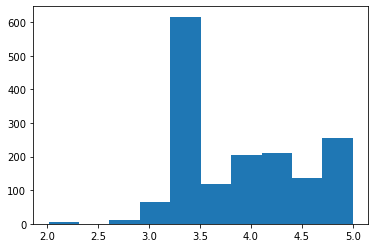

In [173]:
plt.hist(h2n['social_score'])

(array([  1.,   2.,   4.,  26., 586., 150., 236., 198., 131., 285.]),
 array([1.73333333, 2.06      , 2.38666667, 2.71333333, 3.04      ,
        3.36666667, 3.69333333, 4.02      , 4.34666667, 4.67333333,
        5.        ]),
 <a list of 10 Patch objects>)

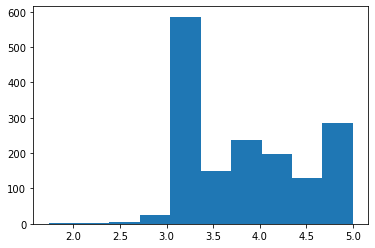

In [175]:
plt.hist(h2n['social_score'])

(array([  2.,   0.,   6.,  32., 590., 154., 209., 205., 124., 297.]),
 array([1.84242424, 2.15818182, 2.47393939, 2.78969697, 3.10545455,
        3.42121212, 3.7369697 , 4.05272727, 4.36848485, 4.68424242,
        5.        ]),
 <a list of 10 Patch objects>)

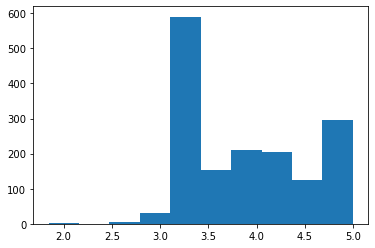

In [177]:
plt.hist(h2n['social_score'])

In [ ]:
""

---
## Decided Not to Use the Social DistancingGrade * Population Density because there isn't a population density available for every county

In [112]:
pop_dens.columns

Index(['GCT_STUB.target-geo-id2', 'Density per square mile of land area'], dtype='object')

In [127]:
pop_dens = pd.read_csv('pop_dens_county.csv').iloc[:,[4,6]]
pop_dens = pop_dens.rename(columns = {'GCT_STUB.target-geo-id2':'fips_code', 'Density per square mile of land area': 'pop_dens'})
rural_dense = pop_dens.merge(rural, on = 'fips_code')
rural_dense

,fips_code,pop_dens,county,state,c3_data_id
0,1005,31.0,Barbour,Alabama,Barbour_Alabama_UnitedStates
1,1011,17.5,Bullock,Alabama,Bullock_Alabama_UnitedStates
2,1013,27.0,Butler,Alabama,Butler_Alabama_UnitedStates
3,1019,46.9,Cherokee,Alabama,Cherokee_Alabama_UnitedStates
4,1023,15.2,Choctaw,Alabama,Choctaw_Alabama_UnitedStates
...,...,...,...,...,...
1613,56037,4.2,Sweetwater,Wyoming,Sweetwater_Wyoming_UnitedStates
1614,56039,5.3,Teton,Wyoming,Teton_Wyoming_UnitedStates
1615,56041,10.1,Uinta,Wyoming,Uinta_Wyoming_UnitedStates
1616,56043,3.8,Washakie,Wyoming,Washakie_Wyoming_UnitedStates
